In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [3]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"] # "Product_Category_B", "Region"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [5]:
def preprocess(data):
    
    # elimino caracteres prohibidos
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = data.Opportunity_Owner == data.Last_Modified_By
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates, axis = 1)
    
    return (data)

In [7]:
import catboost as ctb

In [8]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [9]:
prep = preprocess(data)
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [32]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=0)

In [38]:
cat_vars = [x for x in x_train.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage']

In [39]:
cat_vars

['Region',
 'Territory',
 'Bureaucratic_Code',
 'Source',
 'Billing_Country',
 'Account_Owner',
 'Opportunity_Owner',
 'Currency',
 'Last_Modified_By',
 'Delivery_Quarter']

In [40]:
cat_indexes = [x_train.drop(target, axis=1).columns.get_loc(x) for x in cat_vars]

In [41]:
cat_indexes

[0, 1, 6, 7, 8, 9, 10, 11, 12, 15]

In [83]:
model = ctb.CatBoostClassifier(num_boost_round=5000,
                               learning_rate=0.015,
                               l2_leaf_reg=3.5,
                               depth=8, 
                               max_bin=400,
                               num_leaves=31,
                               rsm=0.98,
                               eval_metric='Logloss',
                               use_best_model=True)

In [84]:
model.fit(x_train.drop(target, axis=1), y_train, eval_set=(x_test.drop(target, axis=1), y_test), cat_features=cat_indexes, early_stopping_rounds=800)

0:	learn: 0.6673675	test: 0.6675799	best: 0.6675799 (0)	total: 17.7ms	remaining: 1m 28s
1:	learn: 0.6451752	test: 0.6455063	best: 0.6455063 (1)	total: 26.2ms	remaining: 1m 5s
2:	learn: 0.6245468	test: 0.6251107	best: 0.6251107 (2)	total: 33ms	remaining: 55s
3:	learn: 0.6037813	test: 0.6044776	best: 0.6044776 (3)	total: 48.4ms	remaining: 1m
4:	learn: 0.5828191	test: 0.5837312	best: 0.5837312 (4)	total: 65ms	remaining: 1m 4s
5:	learn: 0.5647863	test: 0.5659363	best: 0.5659363 (5)	total: 71.2ms	remaining: 59.2s
6:	learn: 0.5459111	test: 0.5473606	best: 0.5473606 (6)	total: 86.4ms	remaining: 1m 1s
7:	learn: 0.5278408	test: 0.5296852	best: 0.5296852 (7)	total: 102ms	remaining: 1m 3s
8:	learn: 0.5087717	test: 0.5108115	best: 0.5108115 (8)	total: 117ms	remaining: 1m 5s
9:	learn: 0.4939930	test: 0.4962422	best: 0.4962422 (9)	total: 122ms	remaining: 1m 1s
10:	learn: 0.4794145	test: 0.4818593	best: 0.4818593 (10)	total: 129ms	remaining: 58.4s
11:	learn: 0.4644284	test: 0.4670438	best: 0.4670438 

99:	learn: 0.1244710	test: 0.1354788	best: 0.1354788 (99)	total: 1.49s	remaining: 1m 12s
100:	learn: 0.1237609	test: 0.1348260	best: 0.1348260 (100)	total: 1.51s	remaining: 1m 13s
101:	learn: 0.1232807	test: 0.1343728	best: 0.1343728 (101)	total: 1.53s	remaining: 1m 13s
102:	learn: 0.1226445	test: 0.1338247	best: 0.1338247 (102)	total: 1.55s	remaining: 1m 13s
103:	learn: 0.1221020	test: 0.1333484	best: 0.1333484 (103)	total: 1.56s	remaining: 1m 13s
104:	learn: 0.1216477	test: 0.1329555	best: 0.1329555 (104)	total: 1.59s	remaining: 1m 14s
105:	learn: 0.1210324	test: 0.1323867	best: 0.1323867 (105)	total: 1.61s	remaining: 1m 14s
106:	learn: 0.1205510	test: 0.1319699	best: 0.1319699 (106)	total: 1.63s	remaining: 1m 14s
107:	learn: 0.1201057	test: 0.1315981	best: 0.1315981 (107)	total: 1.65s	remaining: 1m 14s
108:	learn: 0.1195307	test: 0.1310654	best: 0.1310654 (108)	total: 1.68s	remaining: 1m 15s
109:	learn: 0.1189528	test: 0.1305728	best: 0.1305728 (109)	total: 1.71s	remaining: 1m 15s
1

196:	learn: 0.0956545	test: 0.1114054	best: 0.1114054 (196)	total: 3.39s	remaining: 1m 22s
197:	learn: 0.0953365	test: 0.1111076	best: 0.1111076 (197)	total: 3.42s	remaining: 1m 22s
198:	learn: 0.0952820	test: 0.1110776	best: 0.1110776 (198)	total: 3.44s	remaining: 1m 23s
199:	learn: 0.0951108	test: 0.1109468	best: 0.1109468 (199)	total: 3.46s	remaining: 1m 23s
200:	learn: 0.0951084	test: 0.1109464	best: 0.1109464 (200)	total: 3.47s	remaining: 1m 22s
201:	learn: 0.0948634	test: 0.1107108	best: 0.1107108 (201)	total: 3.49s	remaining: 1m 22s
202:	learn: 0.0948540	test: 0.1107068	best: 0.1107068 (202)	total: 3.5s	remaining: 1m 22s
203:	learn: 0.0946498	test: 0.1104412	best: 0.1104412 (203)	total: 3.52s	remaining: 1m 22s
204:	learn: 0.0944892	test: 0.1102928	best: 0.1102928 (204)	total: 3.53s	remaining: 1m 22s
205:	learn: 0.0943188	test: 0.1101443	best: 0.1101443 (205)	total: 3.55s	remaining: 1m 22s
206:	learn: 0.0940387	test: 0.1098898	best: 0.1098898 (206)	total: 3.58s	remaining: 1m 22s


290:	learn: 0.0853561	test: 0.1035574	best: 0.1035574 (290)	total: 5.06s	remaining: 1m 21s
291:	learn: 0.0852070	test: 0.1034688	best: 0.1034688 (291)	total: 5.08s	remaining: 1m 21s
292:	learn: 0.0851127	test: 0.1033890	best: 0.1033890 (292)	total: 5.1s	remaining: 1m 21s
293:	learn: 0.0851106	test: 0.1033863	best: 0.1033863 (293)	total: 5.11s	remaining: 1m 21s
294:	learn: 0.0850621	test: 0.1033678	best: 0.1033678 (294)	total: 5.12s	remaining: 1m 21s
295:	learn: 0.0849764	test: 0.1033179	best: 0.1033179 (295)	total: 5.14s	remaining: 1m 21s
296:	learn: 0.0848397	test: 0.1032216	best: 0.1032216 (296)	total: 5.16s	remaining: 1m 21s
297:	learn: 0.0847458	test: 0.1031671	best: 0.1031671 (297)	total: 5.17s	remaining: 1m 21s
298:	learn: 0.0847446	test: 0.1031670	best: 0.1031670 (298)	total: 5.18s	remaining: 1m 21s
299:	learn: 0.0847435	test: 0.1031668	best: 0.1031668 (299)	total: 5.18s	remaining: 1m 21s
300:	learn: 0.0847337	test: 0.1031559	best: 0.1031559 (300)	total: 5.2s	remaining: 1m 21s
3

391:	learn: 0.0796691	test: 0.1001564	best: 0.1001564 (391)	total: 6.53s	remaining: 1m 16s
392:	learn: 0.0796668	test: 0.1001553	best: 0.1001553 (392)	total: 6.54s	remaining: 1m 16s
393:	learn: 0.0795877	test: 0.1001297	best: 0.1001297 (393)	total: 6.56s	remaining: 1m 16s
394:	learn: 0.0795560	test: 0.1001147	best: 0.1001147 (394)	total: 6.58s	remaining: 1m 16s
395:	learn: 0.0795069	test: 0.1000832	best: 0.1000832 (395)	total: 6.6s	remaining: 1m 16s
396:	learn: 0.0793993	test: 0.0999752	best: 0.0999752 (396)	total: 6.62s	remaining: 1m 16s
397:	learn: 0.0793603	test: 0.0999461	best: 0.0999461 (397)	total: 6.63s	remaining: 1m 16s
398:	learn: 0.0793603	test: 0.0999461	best: 0.0999461 (398)	total: 6.64s	remaining: 1m 16s
399:	learn: 0.0793156	test: 0.0999349	best: 0.0999349 (399)	total: 6.66s	remaining: 1m 16s
400:	learn: 0.0792788	test: 0.0999095	best: 0.0999095 (400)	total: 6.68s	remaining: 1m 16s
401:	learn: 0.0792758	test: 0.0999044	best: 0.0999044 (401)	total: 6.69s	remaining: 1m 16s


490:	learn: 0.0742520	test: 0.0967397	best: 0.0967397 (490)	total: 8.23s	remaining: 1m 15s
491:	learn: 0.0742330	test: 0.0967303	best: 0.0967303 (491)	total: 8.24s	remaining: 1m 15s
492:	learn: 0.0742321	test: 0.0967303	best: 0.0967303 (492)	total: 8.25s	remaining: 1m 15s
493:	learn: 0.0742082	test: 0.0967327	best: 0.0967303 (492)	total: 8.26s	remaining: 1m 15s
494:	learn: 0.0741335	test: 0.0966841	best: 0.0966841 (494)	total: 8.28s	remaining: 1m 15s
495:	learn: 0.0740540	test: 0.0966499	best: 0.0966499 (495)	total: 8.3s	remaining: 1m 15s
496:	learn: 0.0740104	test: 0.0966435	best: 0.0966435 (496)	total: 8.32s	remaining: 1m 15s
497:	learn: 0.0739232	test: 0.0966051	best: 0.0966051 (497)	total: 8.34s	remaining: 1m 15s
498:	learn: 0.0738671	test: 0.0965834	best: 0.0965834 (498)	total: 8.36s	remaining: 1m 15s
499:	learn: 0.0738671	test: 0.0965834	best: 0.0965834 (499)	total: 8.36s	remaining: 1m 15s
500:	learn: 0.0736695	test: 0.0964031	best: 0.0964031 (500)	total: 8.38s	remaining: 1m 15s


581:	learn: 0.0702227	test: 0.0944277	best: 0.0944277 (581)	total: 9.66s	remaining: 1m 13s
582:	learn: 0.0701743	test: 0.0944047	best: 0.0944047 (582)	total: 9.68s	remaining: 1m 13s
583:	learn: 0.0700002	test: 0.0943230	best: 0.0943230 (583)	total: 9.7s	remaining: 1m 13s
584:	learn: 0.0700002	test: 0.0943230	best: 0.0943230 (584)	total: 9.71s	remaining: 1m 13s
585:	learn: 0.0699958	test: 0.0943264	best: 0.0943230 (584)	total: 9.72s	remaining: 1m 13s
586:	learn: 0.0699838	test: 0.0943205	best: 0.0943205 (586)	total: 9.73s	remaining: 1m 13s
587:	learn: 0.0699283	test: 0.0942975	best: 0.0942975 (587)	total: 9.75s	remaining: 1m 13s
588:	learn: 0.0698751	test: 0.0942724	best: 0.0942724 (588)	total: 9.76s	remaining: 1m 13s
589:	learn: 0.0698495	test: 0.0942668	best: 0.0942668 (589)	total: 9.78s	remaining: 1m 13s
590:	learn: 0.0697827	test: 0.0942248	best: 0.0942248 (590)	total: 9.8s	remaining: 1m 13s
591:	learn: 0.0697827	test: 0.0942247	best: 0.0942247 (591)	total: 9.8s	remaining: 1m 12s
59

673:	learn: 0.0666825	test: 0.0922606	best: 0.0922606 (673)	total: 11.2s	remaining: 1m 11s
674:	learn: 0.0665517	test: 0.0921818	best: 0.0921818 (674)	total: 11.2s	remaining: 1m 11s
675:	learn: 0.0665425	test: 0.0921826	best: 0.0921818 (674)	total: 11.2s	remaining: 1m 11s
676:	learn: 0.0665315	test: 0.0921772	best: 0.0921772 (676)	total: 11.2s	remaining: 1m 11s
677:	learn: 0.0664771	test: 0.0921342	best: 0.0921342 (677)	total: 11.2s	remaining: 1m 11s
678:	learn: 0.0664047	test: 0.0920986	best: 0.0920986 (678)	total: 11.3s	remaining: 1m 11s
679:	learn: 0.0663899	test: 0.0920958	best: 0.0920958 (679)	total: 11.3s	remaining: 1m 11s
680:	learn: 0.0663758	test: 0.0920918	best: 0.0920918 (680)	total: 11.3s	remaining: 1m 11s
681:	learn: 0.0662845	test: 0.0920947	best: 0.0920918 (680)	total: 11.3s	remaining: 1m 11s
682:	learn: 0.0662827	test: 0.0920937	best: 0.0920918 (680)	total: 11.3s	remaining: 1m 11s
683:	learn: 0.0662765	test: 0.0920928	best: 0.0920918 (680)	total: 11.3s	remaining: 1m 11s

770:	learn: 0.0627243	test: 0.0899340	best: 0.0899340 (770)	total: 12.6s	remaining: 1m 9s
771:	learn: 0.0627063	test: 0.0899284	best: 0.0899284 (771)	total: 12.7s	remaining: 1m 9s
772:	learn: 0.0626845	test: 0.0899214	best: 0.0899214 (772)	total: 12.7s	remaining: 1m 9s
773:	learn: 0.0626747	test: 0.0899176	best: 0.0899176 (773)	total: 12.7s	remaining: 1m 9s
774:	learn: 0.0626525	test: 0.0899184	best: 0.0899176 (773)	total: 12.7s	remaining: 1m 9s
775:	learn: 0.0626293	test: 0.0899107	best: 0.0899107 (775)	total: 12.7s	remaining: 1m 9s
776:	learn: 0.0626129	test: 0.0899010	best: 0.0899010 (776)	total: 12.7s	remaining: 1m 9s
777:	learn: 0.0625006	test: 0.0898102	best: 0.0898102 (777)	total: 12.8s	remaining: 1m 9s
778:	learn: 0.0624853	test: 0.0898043	best: 0.0898043 (778)	total: 12.8s	remaining: 1m 9s
779:	learn: 0.0624737	test: 0.0898067	best: 0.0898043 (778)	total: 12.8s	remaining: 1m 9s
780:	learn: 0.0624253	test: 0.0897757	best: 0.0897757 (780)	total: 12.8s	remaining: 1m 9s
781:	learn

862:	learn: 0.0599165	test: 0.0883539	best: 0.0883507 (861)	total: 14.3s	remaining: 1m 8s
863:	learn: 0.0598981	test: 0.0883423	best: 0.0883423 (863)	total: 14.3s	remaining: 1m 8s
864:	learn: 0.0598803	test: 0.0883443	best: 0.0883423 (863)	total: 14.4s	remaining: 1m 8s
865:	learn: 0.0598462	test: 0.0883355	best: 0.0883355 (865)	total: 14.4s	remaining: 1m 8s
866:	learn: 0.0598274	test: 0.0883199	best: 0.0883199 (866)	total: 14.4s	remaining: 1m 8s
867:	learn: 0.0598135	test: 0.0883191	best: 0.0883191 (867)	total: 14.5s	remaining: 1m 8s
868:	learn: 0.0598004	test: 0.0883134	best: 0.0883134 (868)	total: 14.5s	remaining: 1m 8s
869:	learn: 0.0597987	test: 0.0883119	best: 0.0883119 (869)	total: 14.5s	remaining: 1m 8s
870:	learn: 0.0597938	test: 0.0883116	best: 0.0883116 (870)	total: 14.5s	remaining: 1m 8s
871:	learn: 0.0597764	test: 0.0883028	best: 0.0883028 (871)	total: 14.6s	remaining: 1m 8s
872:	learn: 0.0597692	test: 0.0883021	best: 0.0883021 (872)	total: 14.6s	remaining: 1m 8s
873:	learn

957:	learn: 0.0568508	test: 0.0869641	best: 0.0869641 (957)	total: 16.2s	remaining: 1m 8s
958:	learn: 0.0568356	test: 0.0869637	best: 0.0869637 (958)	total: 16.2s	remaining: 1m 8s
959:	learn: 0.0568276	test: 0.0869615	best: 0.0869615 (959)	total: 16.2s	remaining: 1m 8s
960:	learn: 0.0568141	test: 0.0869616	best: 0.0869615 (959)	total: 16.2s	remaining: 1m 8s
961:	learn: 0.0568027	test: 0.0869620	best: 0.0869615 (959)	total: 16.3s	remaining: 1m 8s
962:	learn: 0.0567961	test: 0.0869627	best: 0.0869615 (959)	total: 16.3s	remaining: 1m 8s
963:	learn: 0.0567927	test: 0.0869605	best: 0.0869605 (963)	total: 16.3s	remaining: 1m 8s
964:	learn: 0.0567854	test: 0.0869466	best: 0.0869466 (964)	total: 16.3s	remaining: 1m 8s
965:	learn: 0.0567194	test: 0.0869260	best: 0.0869260 (965)	total: 16.3s	remaining: 1m 8s
966:	learn: 0.0566245	test: 0.0868471	best: 0.0868471 (966)	total: 16.4s	remaining: 1m 8s
967:	learn: 0.0566084	test: 0.0868482	best: 0.0868471 (966)	total: 16.4s	remaining: 1m 8s
968:	learn

1053:	learn: 0.0541649	test: 0.0858208	best: 0.0858208 (1053)	total: 18.1s	remaining: 1m 7s
1054:	learn: 0.0541285	test: 0.0858068	best: 0.0858068 (1054)	total: 18.1s	remaining: 1m 7s
1055:	learn: 0.0541028	test: 0.0857969	best: 0.0857969 (1055)	total: 18.1s	remaining: 1m 7s
1056:	learn: 0.0541028	test: 0.0857969	best: 0.0857969 (1055)	total: 18.1s	remaining: 1m 7s
1057:	learn: 0.0540958	test: 0.0857955	best: 0.0857955 (1057)	total: 18.2s	remaining: 1m 7s
1058:	learn: 0.0540311	test: 0.0856974	best: 0.0856974 (1058)	total: 18.2s	remaining: 1m 7s
1059:	learn: 0.0539926	test: 0.0856831	best: 0.0856831 (1059)	total: 18.2s	remaining: 1m 7s
1060:	learn: 0.0539715	test: 0.0856847	best: 0.0856831 (1059)	total: 18.2s	remaining: 1m 7s
1061:	learn: 0.0539625	test: 0.0856812	best: 0.0856812 (1061)	total: 18.2s	remaining: 1m 7s
1062:	learn: 0.0539568	test: 0.0856753	best: 0.0856753 (1062)	total: 18.3s	remaining: 1m 7s
1063:	learn: 0.0539283	test: 0.0856870	best: 0.0856753 (1062)	total: 18.3s	remai

1146:	learn: 0.0512035	test: 0.0846072	best: 0.0846072 (1146)	total: 19.8s	remaining: 1m 6s
1147:	learn: 0.0511789	test: 0.0846101	best: 0.0846072 (1146)	total: 19.8s	remaining: 1m 6s
1148:	learn: 0.0511681	test: 0.0846047	best: 0.0846047 (1148)	total: 19.8s	remaining: 1m 6s
1149:	learn: 0.0511133	test: 0.0845605	best: 0.0845605 (1149)	total: 19.9s	remaining: 1m 6s
1150:	learn: 0.0511082	test: 0.0845554	best: 0.0845554 (1150)	total: 19.9s	remaining: 1m 6s
1151:	learn: 0.0510368	test: 0.0845485	best: 0.0845485 (1151)	total: 19.9s	remaining: 1m 6s
1152:	learn: 0.0509615	test: 0.0844960	best: 0.0844960 (1152)	total: 19.9s	remaining: 1m 6s
1153:	learn: 0.0509389	test: 0.0844861	best: 0.0844861 (1153)	total: 19.9s	remaining: 1m 6s
1154:	learn: 0.0509320	test: 0.0844817	best: 0.0844817 (1154)	total: 19.9s	remaining: 1m 6s
1155:	learn: 0.0509210	test: 0.0844780	best: 0.0844780 (1155)	total: 20s	remaining: 1m 6s
1156:	learn: 0.0509120	test: 0.0844784	best: 0.0844780 (1155)	total: 20s	remaining

1241:	learn: 0.0486157	test: 0.0832858	best: 0.0832843 (1240)	total: 21.5s	remaining: 1m 5s
1242:	learn: 0.0485369	test: 0.0832748	best: 0.0832748 (1242)	total: 21.5s	remaining: 1m 5s
1243:	learn: 0.0485256	test: 0.0832689	best: 0.0832689 (1243)	total: 21.5s	remaining: 1m 5s
1244:	learn: 0.0485186	test: 0.0832697	best: 0.0832689 (1243)	total: 21.5s	remaining: 1m 4s
1245:	learn: 0.0485058	test: 0.0832635	best: 0.0832635 (1245)	total: 21.6s	remaining: 1m 4s
1246:	learn: 0.0484567	test: 0.0832396	best: 0.0832396 (1246)	total: 21.6s	remaining: 1m 4s
1247:	learn: 0.0484500	test: 0.0832395	best: 0.0832395 (1247)	total: 21.6s	remaining: 1m 4s
1248:	learn: 0.0484320	test: 0.0832282	best: 0.0832282 (1248)	total: 21.6s	remaining: 1m 4s
1249:	learn: 0.0483658	test: 0.0832133	best: 0.0832133 (1249)	total: 21.6s	remaining: 1m 4s
1250:	learn: 0.0483050	test: 0.0831480	best: 0.0831480 (1250)	total: 21.6s	remaining: 1m 4s
1251:	learn: 0.0482968	test: 0.0831459	best: 0.0831459 (1251)	total: 21.7s	remai

1334:	learn: 0.0460074	test: 0.0820230	best: 0.0820190 (1333)	total: 23.2s	remaining: 1m 3s
1335:	learn: 0.0459752	test: 0.0819947	best: 0.0819947 (1335)	total: 23.2s	remaining: 1m 3s
1336:	learn: 0.0459652	test: 0.0819758	best: 0.0819758 (1336)	total: 23.2s	remaining: 1m 3s
1337:	learn: 0.0459581	test: 0.0819751	best: 0.0819751 (1337)	total: 23.2s	remaining: 1m 3s
1338:	learn: 0.0459342	test: 0.0819741	best: 0.0819741 (1338)	total: 23.3s	remaining: 1m 3s
1339:	learn: 0.0459164	test: 0.0819457	best: 0.0819457 (1339)	total: 23.3s	remaining: 1m 3s
1340:	learn: 0.0458934	test: 0.0819199	best: 0.0819199 (1340)	total: 23.3s	remaining: 1m 3s
1341:	learn: 0.0458522	test: 0.0819026	best: 0.0819026 (1341)	total: 23.3s	remaining: 1m 3s
1342:	learn: 0.0458153	test: 0.0818967	best: 0.0818967 (1342)	total: 23.3s	remaining: 1m 3s
1343:	learn: 0.0458002	test: 0.0818867	best: 0.0818867 (1343)	total: 23.3s	remaining: 1m 3s
1344:	learn: 0.0457820	test: 0.0818793	best: 0.0818793 (1344)	total: 23.4s	remai

1433:	learn: 0.0437845	test: 0.0811020	best: 0.0811020 (1433)	total: 25.1s	remaining: 1m 2s
1434:	learn: 0.0437714	test: 0.0810949	best: 0.0810949 (1434)	total: 25.1s	remaining: 1m 2s
1435:	learn: 0.0437637	test: 0.0810931	best: 0.0810931 (1435)	total: 25.1s	remaining: 1m 2s
1436:	learn: 0.0437206	test: 0.0810569	best: 0.0810569 (1436)	total: 25.1s	remaining: 1m 2s
1437:	learn: 0.0437143	test: 0.0810520	best: 0.0810520 (1437)	total: 25.1s	remaining: 1m 2s
1438:	learn: 0.0437032	test: 0.0810555	best: 0.0810520 (1437)	total: 25.1s	remaining: 1m 2s
1439:	learn: 0.0436805	test: 0.0810443	best: 0.0810443 (1439)	total: 25.2s	remaining: 1m 2s
1440:	learn: 0.0436663	test: 0.0810383	best: 0.0810383 (1440)	total: 25.2s	remaining: 1m 2s
1441:	learn: 0.0436541	test: 0.0810300	best: 0.0810300 (1441)	total: 25.2s	remaining: 1m 2s
1442:	learn: 0.0436440	test: 0.0810291	best: 0.0810291 (1442)	total: 25.2s	remaining: 1m 2s
1443:	learn: 0.0435882	test: 0.0810082	best: 0.0810082 (1443)	total: 25.2s	remai

1523:	learn: 0.0418641	test: 0.0803322	best: 0.0803322 (1523)	total: 26.7s	remaining: 1m 1s
1524:	learn: 0.0418581	test: 0.0803277	best: 0.0803277 (1524)	total: 26.8s	remaining: 1m 1s
1525:	learn: 0.0418200	test: 0.0803106	best: 0.0803106 (1525)	total: 26.8s	remaining: 1m
1526:	learn: 0.0417991	test: 0.0803046	best: 0.0803046 (1526)	total: 26.8s	remaining: 1m
1527:	learn: 0.0417817	test: 0.0802964	best: 0.0802964 (1527)	total: 26.8s	remaining: 1m
1528:	learn: 0.0417710	test: 0.0802882	best: 0.0802882 (1528)	total: 26.8s	remaining: 1m
1529:	learn: 0.0417634	test: 0.0802860	best: 0.0802860 (1529)	total: 26.9s	remaining: 1m
1530:	learn: 0.0417515	test: 0.0802949	best: 0.0802860 (1529)	total: 26.9s	remaining: 1m
1531:	learn: 0.0417213	test: 0.0802962	best: 0.0802860 (1529)	total: 26.9s	remaining: 1m
1532:	learn: 0.0417161	test: 0.0802963	best: 0.0802860 (1529)	total: 26.9s	remaining: 1m
1533:	learn: 0.0417098	test: 0.0802921	best: 0.0802860 (1529)	total: 26.9s	remaining: 1m
1534:	learn: 0.

1617:	learn: 0.0399194	test: 0.0795667	best: 0.0795667 (1617)	total: 28.4s	remaining: 59.4s
1618:	learn: 0.0398384	test: 0.0795011	best: 0.0795011 (1618)	total: 28.4s	remaining: 59.4s
1619:	learn: 0.0398353	test: 0.0794990	best: 0.0794990 (1619)	total: 28.5s	remaining: 59.4s
1620:	learn: 0.0398207	test: 0.0794918	best: 0.0794918 (1620)	total: 28.5s	remaining: 59.4s
1621:	learn: 0.0397992	test: 0.0794849	best: 0.0794849 (1621)	total: 28.5s	remaining: 59.3s
1622:	learn: 0.0397936	test: 0.0794812	best: 0.0794812 (1622)	total: 28.5s	remaining: 59.3s
1623:	learn: 0.0397861	test: 0.0794799	best: 0.0794799 (1623)	total: 28.5s	remaining: 59.3s
1624:	learn: 0.0397808	test: 0.0794806	best: 0.0794799 (1623)	total: 28.6s	remaining: 59.3s
1625:	learn: 0.0397680	test: 0.0794783	best: 0.0794783 (1625)	total: 28.6s	remaining: 59.3s
1626:	learn: 0.0397576	test: 0.0794703	best: 0.0794703 (1626)	total: 28.6s	remaining: 59.3s
1627:	learn: 0.0397530	test: 0.0794652	best: 0.0794652 (1627)	total: 28.6s	remai

1707:	learn: 0.0381914	test: 0.0789551	best: 0.0789551 (1707)	total: 30.1s	remaining: 58s
1708:	learn: 0.0381822	test: 0.0789488	best: 0.0789488 (1708)	total: 30.1s	remaining: 58s
1709:	learn: 0.0381739	test: 0.0789518	best: 0.0789488 (1708)	total: 30.1s	remaining: 58s
1710:	learn: 0.0381617	test: 0.0789462	best: 0.0789462 (1710)	total: 30.2s	remaining: 58s
1711:	learn: 0.0381413	test: 0.0789344	best: 0.0789344 (1711)	total: 30.2s	remaining: 58s
1712:	learn: 0.0381370	test: 0.0789292	best: 0.0789292 (1712)	total: 30.2s	remaining: 57.9s
1713:	learn: 0.0380910	test: 0.0789273	best: 0.0789273 (1713)	total: 30.2s	remaining: 57.9s
1714:	learn: 0.0380383	test: 0.0788973	best: 0.0788973 (1714)	total: 30.2s	remaining: 57.9s
1715:	learn: 0.0380283	test: 0.0788894	best: 0.0788894 (1715)	total: 30.2s	remaining: 57.9s
1716:	learn: 0.0380158	test: 0.0788900	best: 0.0788894 (1715)	total: 30.3s	remaining: 57.9s
1717:	learn: 0.0380124	test: 0.0788908	best: 0.0788894 (1715)	total: 30.3s	remaining: 57.8

1808:	learn: 0.0363852	test: 0.0782677	best: 0.0782677 (1808)	total: 32s	remaining: 56.4s
1809:	learn: 0.0363605	test: 0.0782684	best: 0.0782677 (1808)	total: 32s	remaining: 56.4s
1810:	learn: 0.0363532	test: 0.0782661	best: 0.0782661 (1810)	total: 32s	remaining: 56.3s
1811:	learn: 0.0363263	test: 0.0782696	best: 0.0782661 (1810)	total: 32s	remaining: 56.3s
1812:	learn: 0.0363056	test: 0.0782585	best: 0.0782585 (1812)	total: 32s	remaining: 56.3s
1813:	learn: 0.0363018	test: 0.0782553	best: 0.0782553 (1813)	total: 32s	remaining: 56.3s
1814:	learn: 0.0362624	test: 0.0782335	best: 0.0782335 (1814)	total: 32.1s	remaining: 56.3s
1815:	learn: 0.0362419	test: 0.0782436	best: 0.0782335 (1814)	total: 32.1s	remaining: 56.2s
1816:	learn: 0.0362135	test: 0.0782135	best: 0.0782135 (1816)	total: 32.1s	remaining: 56.2s
1817:	learn: 0.0362021	test: 0.0782098	best: 0.0782098 (1817)	total: 32.1s	remaining: 56.2s
1818:	learn: 0.0361906	test: 0.0781990	best: 0.0781990 (1818)	total: 32.1s	remaining: 56.2s


1902:	learn: 0.0351334	test: 0.0777980	best: 0.0777980 (1902)	total: 33.6s	remaining: 54.7s
1903:	learn: 0.0351157	test: 0.0777969	best: 0.0777969 (1903)	total: 33.6s	remaining: 54.7s
1904:	learn: 0.0351076	test: 0.0777928	best: 0.0777928 (1904)	total: 33.7s	remaining: 54.7s
1905:	learn: 0.0351013	test: 0.0777913	best: 0.0777913 (1905)	total: 33.7s	remaining: 54.7s
1906:	learn: 0.0350947	test: 0.0777862	best: 0.0777862 (1906)	total: 33.7s	remaining: 54.7s
1907:	learn: 0.0350758	test: 0.0777877	best: 0.0777862 (1906)	total: 33.7s	remaining: 54.7s
1908:	learn: 0.0350653	test: 0.0777945	best: 0.0777862 (1906)	total: 33.8s	remaining: 54.6s
1909:	learn: 0.0350571	test: 0.0777985	best: 0.0777862 (1906)	total: 33.8s	remaining: 54.6s
1910:	learn: 0.0350439	test: 0.0777990	best: 0.0777862 (1906)	total: 33.8s	remaining: 54.6s
1911:	learn: 0.0350336	test: 0.0778060	best: 0.0777862 (1906)	total: 33.8s	remaining: 54.6s
1912:	learn: 0.0350241	test: 0.0778064	best: 0.0777862 (1906)	total: 33.8s	remai

1992:	learn: 0.0338969	test: 0.0775077	best: 0.0774933 (1989)	total: 35.3s	remaining: 53.2s
1993:	learn: 0.0338853	test: 0.0775119	best: 0.0774933 (1989)	total: 35.3s	remaining: 53.2s
1994:	learn: 0.0338648	test: 0.0775009	best: 0.0774933 (1989)	total: 35.3s	remaining: 53.2s
1995:	learn: 0.0338575	test: 0.0775045	best: 0.0774933 (1989)	total: 35.3s	remaining: 53.2s
1996:	learn: 0.0338539	test: 0.0775032	best: 0.0774933 (1989)	total: 35.3s	remaining: 53.2s
1997:	learn: 0.0338189	test: 0.0774763	best: 0.0774763 (1997)	total: 35.4s	remaining: 53.1s
1998:	learn: 0.0338032	test: 0.0774723	best: 0.0774723 (1998)	total: 35.4s	remaining: 53.1s
1999:	learn: 0.0337985	test: 0.0774743	best: 0.0774723 (1998)	total: 35.4s	remaining: 53.1s
2000:	learn: 0.0337876	test: 0.0774808	best: 0.0774723 (1998)	total: 35.4s	remaining: 53.1s
2001:	learn: 0.0337639	test: 0.0774942	best: 0.0774723 (1998)	total: 35.4s	remaining: 53.1s
2002:	learn: 0.0337504	test: 0.0774961	best: 0.0774723 (1998)	total: 35.5s	remai

2090:	learn: 0.0327213	test: 0.0771782	best: 0.0771729 (2085)	total: 37.2s	remaining: 51.7s
2091:	learn: 0.0327129	test: 0.0771863	best: 0.0771729 (2085)	total: 37.2s	remaining: 51.7s
2092:	learn: 0.0326974	test: 0.0771827	best: 0.0771729 (2085)	total: 37.2s	remaining: 51.7s
2093:	learn: 0.0326891	test: 0.0771807	best: 0.0771729 (2085)	total: 37.2s	remaining: 51.6s
2094:	learn: 0.0326832	test: 0.0771814	best: 0.0771729 (2085)	total: 37.2s	remaining: 51.6s
2095:	learn: 0.0326807	test: 0.0771760	best: 0.0771729 (2085)	total: 37.2s	remaining: 51.6s
2096:	learn: 0.0326714	test: 0.0771767	best: 0.0771729 (2085)	total: 37.3s	remaining: 51.6s
2097:	learn: 0.0326413	test: 0.0771889	best: 0.0771729 (2085)	total: 37.3s	remaining: 51.6s
2098:	learn: 0.0326345	test: 0.0771923	best: 0.0771729 (2085)	total: 37.3s	remaining: 51.5s
2099:	learn: 0.0326247	test: 0.0771905	best: 0.0771729 (2085)	total: 37.3s	remaining: 51.5s
2100:	learn: 0.0326068	test: 0.0771823	best: 0.0771729 (2085)	total: 37.3s	remai

2188:	learn: 0.0314216	test: 0.0767653	best: 0.0767653 (2188)	total: 39s	remaining: 50.1s
2189:	learn: 0.0314149	test: 0.0767596	best: 0.0767596 (2189)	total: 39.1s	remaining: 50.1s
2190:	learn: 0.0313933	test: 0.0767511	best: 0.0767511 (2190)	total: 39.1s	remaining: 50.1s
2191:	learn: 0.0313825	test: 0.0767449	best: 0.0767449 (2191)	total: 39.1s	remaining: 50.1s
2192:	learn: 0.0313781	test: 0.0767409	best: 0.0767409 (2192)	total: 39.1s	remaining: 50.1s
2193:	learn: 0.0313689	test: 0.0767449	best: 0.0767409 (2192)	total: 39.1s	remaining: 50.1s
2194:	learn: 0.0313378	test: 0.0767319	best: 0.0767319 (2194)	total: 39.2s	remaining: 50s
2195:	learn: 0.0313222	test: 0.0767213	best: 0.0767213 (2195)	total: 39.2s	remaining: 50s
2196:	learn: 0.0312898	test: 0.0766812	best: 0.0766812 (2196)	total: 39.2s	remaining: 50s
2197:	learn: 0.0312853	test: 0.0766812	best: 0.0766812 (2196)	total: 39.2s	remaining: 50s
2198:	learn: 0.0312770	test: 0.0766822	best: 0.0766812 (2196)	total: 39.2s	remaining: 50s


2281:	learn: 0.0302741	test: 0.0763725	best: 0.0763725 (2281)	total: 40.7s	remaining: 48.5s
2282:	learn: 0.0302625	test: 0.0763631	best: 0.0763631 (2282)	total: 40.7s	remaining: 48.5s
2283:	learn: 0.0302593	test: 0.0763608	best: 0.0763608 (2283)	total: 40.8s	remaining: 48.5s
2284:	learn: 0.0302505	test: 0.0763656	best: 0.0763608 (2283)	total: 40.8s	remaining: 48.4s
2285:	learn: 0.0302466	test: 0.0763673	best: 0.0763608 (2283)	total: 40.8s	remaining: 48.4s
2286:	learn: 0.0302399	test: 0.0763611	best: 0.0763608 (2283)	total: 40.8s	remaining: 48.4s
2287:	learn: 0.0302361	test: 0.0763578	best: 0.0763578 (2287)	total: 40.8s	remaining: 48.4s
2288:	learn: 0.0302315	test: 0.0763566	best: 0.0763566 (2288)	total: 40.8s	remaining: 48.4s
2289:	learn: 0.0302173	test: 0.0763562	best: 0.0763562 (2289)	total: 40.9s	remaining: 48.4s
2290:	learn: 0.0302155	test: 0.0763581	best: 0.0763562 (2289)	total: 40.9s	remaining: 48.3s
2291:	learn: 0.0302126	test: 0.0763546	best: 0.0763546 (2291)	total: 40.9s	remai

2373:	learn: 0.0293956	test: 0.0761103	best: 0.0761044 (2359)	total: 42.4s	remaining: 46.9s
2374:	learn: 0.0293934	test: 0.0761078	best: 0.0761044 (2359)	total: 42.4s	remaining: 46.9s
2375:	learn: 0.0293589	test: 0.0760767	best: 0.0760767 (2375)	total: 42.4s	remaining: 46.8s
2376:	learn: 0.0293541	test: 0.0760750	best: 0.0760750 (2376)	total: 42.4s	remaining: 46.8s
2377:	learn: 0.0293478	test: 0.0760794	best: 0.0760750 (2376)	total: 42.5s	remaining: 46.8s
2378:	learn: 0.0293374	test: 0.0760698	best: 0.0760698 (2378)	total: 42.5s	remaining: 46.8s
2379:	learn: 0.0293135	test: 0.0760686	best: 0.0760686 (2379)	total: 42.5s	remaining: 46.8s
2380:	learn: 0.0293080	test: 0.0760697	best: 0.0760686 (2379)	total: 42.5s	remaining: 46.8s
2381:	learn: 0.0293042	test: 0.0760714	best: 0.0760686 (2379)	total: 42.5s	remaining: 46.7s
2382:	learn: 0.0293010	test: 0.0760724	best: 0.0760686 (2379)	total: 42.5s	remaining: 46.7s
2383:	learn: 0.0292959	test: 0.0760720	best: 0.0760686 (2379)	total: 42.6s	remai

2470:	learn: 0.0283608	test: 0.0758996	best: 0.0758996 (2470)	total: 44.2s	remaining: 45.3s
2471:	learn: 0.0283404	test: 0.0758902	best: 0.0758902 (2471)	total: 44.3s	remaining: 45.3s
2472:	learn: 0.0283382	test: 0.0758880	best: 0.0758880 (2472)	total: 44.3s	remaining: 45.3s
2473:	learn: 0.0283183	test: 0.0758751	best: 0.0758751 (2473)	total: 44.3s	remaining: 45.2s
2474:	learn: 0.0283074	test: 0.0758814	best: 0.0758751 (2473)	total: 44.3s	remaining: 45.2s
2475:	learn: 0.0282921	test: 0.0758775	best: 0.0758751 (2473)	total: 44.3s	remaining: 45.2s
2476:	learn: 0.0282822	test: 0.0758745	best: 0.0758745 (2476)	total: 44.4s	remaining: 45.2s
2477:	learn: 0.0282688	test: 0.0758693	best: 0.0758693 (2477)	total: 44.4s	remaining: 45.2s
2478:	learn: 0.0282635	test: 0.0758744	best: 0.0758693 (2477)	total: 44.4s	remaining: 45.1s
2479:	learn: 0.0282393	test: 0.0758771	best: 0.0758693 (2477)	total: 44.4s	remaining: 45.1s
2480:	learn: 0.0282268	test: 0.0758682	best: 0.0758682 (2480)	total: 44.4s	remai

2569:	learn: 0.0273612	test: 0.0756763	best: 0.0756713 (2567)	total: 46.1s	remaining: 43.6s
2570:	learn: 0.0273562	test: 0.0756776	best: 0.0756713 (2567)	total: 46.1s	remaining: 43.6s
2571:	learn: 0.0273540	test: 0.0756748	best: 0.0756713 (2567)	total: 46.1s	remaining: 43.6s
2572:	learn: 0.0273356	test: 0.0756580	best: 0.0756580 (2572)	total: 46.2s	remaining: 43.5s
2573:	learn: 0.0273185	test: 0.0756614	best: 0.0756580 (2572)	total: 46.2s	remaining: 43.5s
2574:	learn: 0.0272955	test: 0.0756438	best: 0.0756438 (2574)	total: 46.2s	remaining: 43.5s
2575:	learn: 0.0272770	test: 0.0756387	best: 0.0756387 (2575)	total: 46.2s	remaining: 43.5s
2576:	learn: 0.0272676	test: 0.0756419	best: 0.0756387 (2575)	total: 46.2s	remaining: 43.5s
2577:	learn: 0.0272641	test: 0.0756442	best: 0.0756387 (2575)	total: 46.3s	remaining: 43.5s
2578:	learn: 0.0272477	test: 0.0756497	best: 0.0756387 (2575)	total: 46.3s	remaining: 43.4s
2579:	learn: 0.0272450	test: 0.0756461	best: 0.0756387 (2575)	total: 46.3s	remai

2664:	learn: 0.0263572	test: 0.0753063	best: 0.0752963 (2659)	total: 48s	remaining: 42s
2665:	learn: 0.0263452	test: 0.0753055	best: 0.0752963 (2659)	total: 48s	remaining: 42s
2666:	learn: 0.0263359	test: 0.0753157	best: 0.0752963 (2659)	total: 48s	remaining: 42s
2667:	learn: 0.0263061	test: 0.0752978	best: 0.0752963 (2659)	total: 48s	remaining: 42s
2668:	learn: 0.0263020	test: 0.0752989	best: 0.0752963 (2659)	total: 48.1s	remaining: 42s
2669:	learn: 0.0262862	test: 0.0752831	best: 0.0752831 (2669)	total: 48.1s	remaining: 42s
2670:	learn: 0.0262751	test: 0.0752826	best: 0.0752826 (2670)	total: 48.1s	remaining: 41.9s
2671:	learn: 0.0262723	test: 0.0752782	best: 0.0752782 (2671)	total: 48.1s	remaining: 41.9s
2672:	learn: 0.0262694	test: 0.0752780	best: 0.0752780 (2672)	total: 48.1s	remaining: 41.9s
2673:	learn: 0.0262552	test: 0.0752628	best: 0.0752628 (2673)	total: 48.2s	remaining: 41.9s
2674:	learn: 0.0262443	test: 0.0752625	best: 0.0752625 (2674)	total: 48.2s	remaining: 41.9s
2675:	le

2760:	learn: 0.0254653	test: 0.0751751	best: 0.0751715 (2743)	total: 50.1s	remaining: 40.6s
2761:	learn: 0.0254428	test: 0.0751639	best: 0.0751639 (2761)	total: 50.1s	remaining: 40.6s
2762:	learn: 0.0254329	test: 0.0751488	best: 0.0751488 (2762)	total: 50.1s	remaining: 40.6s
2763:	learn: 0.0254302	test: 0.0751525	best: 0.0751488 (2762)	total: 50.1s	remaining: 40.6s
2764:	learn: 0.0254254	test: 0.0751528	best: 0.0751488 (2762)	total: 50.1s	remaining: 40.5s
2765:	learn: 0.0254139	test: 0.0751649	best: 0.0751488 (2762)	total: 50.2s	remaining: 40.5s
2766:	learn: 0.0254051	test: 0.0751459	best: 0.0751459 (2766)	total: 50.2s	remaining: 40.5s
2767:	learn: 0.0253995	test: 0.0751272	best: 0.0751272 (2767)	total: 50.2s	remaining: 40.5s
2768:	learn: 0.0253824	test: 0.0751314	best: 0.0751272 (2767)	total: 50.2s	remaining: 40.5s
2769:	learn: 0.0253715	test: 0.0751281	best: 0.0751272 (2767)	total: 50.2s	remaining: 40.4s
2770:	learn: 0.0253692	test: 0.0751272	best: 0.0751272 (2767)	total: 50.2s	remai

2855:	learn: 0.0245236	test: 0.0748906	best: 0.0748906 (2855)	total: 52s	remaining: 39s
2856:	learn: 0.0245098	test: 0.0748944	best: 0.0748906 (2855)	total: 52s	remaining: 39s
2857:	learn: 0.0245084	test: 0.0748920	best: 0.0748906 (2855)	total: 52s	remaining: 39s
2858:	learn: 0.0245068	test: 0.0748872	best: 0.0748872 (2858)	total: 52s	remaining: 38.9s
2859:	learn: 0.0245007	test: 0.0748902	best: 0.0748872 (2858)	total: 52s	remaining: 38.9s
2860:	learn: 0.0244782	test: 0.0748849	best: 0.0748849 (2860)	total: 52s	remaining: 38.9s
2861:	learn: 0.0244701	test: 0.0748926	best: 0.0748849 (2860)	total: 52.1s	remaining: 38.9s
2862:	learn: 0.0244678	test: 0.0748957	best: 0.0748849 (2860)	total: 52.1s	remaining: 38.9s
2863:	learn: 0.0244626	test: 0.0748828	best: 0.0748828 (2863)	total: 52.1s	remaining: 38.8s
2864:	learn: 0.0244506	test: 0.0748938	best: 0.0748828 (2863)	total: 52.1s	remaining: 38.8s
2865:	learn: 0.0244470	test: 0.0748976	best: 0.0748828 (2863)	total: 52.1s	remaining: 38.8s
2866:	

2949:	learn: 0.0235955	test: 0.0747933	best: 0.0747824 (2947)	total: 53.6s	remaining: 37.3s
2950:	learn: 0.0235872	test: 0.0747797	best: 0.0747797 (2950)	total: 53.7s	remaining: 37.3s
2951:	learn: 0.0235859	test: 0.0747774	best: 0.0747774 (2951)	total: 53.7s	remaining: 37.2s
2952:	learn: 0.0235810	test: 0.0747719	best: 0.0747719 (2952)	total: 53.7s	remaining: 37.2s
2953:	learn: 0.0235679	test: 0.0747526	best: 0.0747526 (2953)	total: 53.7s	remaining: 37.2s
2954:	learn: 0.0235679	test: 0.0747526	best: 0.0747526 (2953)	total: 53.7s	remaining: 37.2s
2955:	learn: 0.0235590	test: 0.0747511	best: 0.0747511 (2955)	total: 53.7s	remaining: 37.2s
2956:	learn: 0.0235531	test: 0.0747435	best: 0.0747435 (2956)	total: 53.7s	remaining: 37.1s
2957:	learn: 0.0235444	test: 0.0747423	best: 0.0747423 (2957)	total: 53.8s	remaining: 37.1s
2958:	learn: 0.0235403	test: 0.0747423	best: 0.0747423 (2958)	total: 53.8s	remaining: 37.1s
2959:	learn: 0.0235261	test: 0.0747278	best: 0.0747278 (2959)	total: 53.8s	remai

3046:	learn: 0.0229374	test: 0.0744956	best: 0.0744807 (3042)	total: 55.3s	remaining: 35.4s
3047:	learn: 0.0229270	test: 0.0744847	best: 0.0744807 (3042)	total: 55.3s	remaining: 35.4s
3048:	learn: 0.0229259	test: 0.0744826	best: 0.0744807 (3042)	total: 55.3s	remaining: 35.4s
3049:	learn: 0.0229255	test: 0.0744826	best: 0.0744807 (3042)	total: 55.3s	remaining: 35.4s
3050:	learn: 0.0229235	test: 0.0744830	best: 0.0744807 (3042)	total: 55.3s	remaining: 35.4s
3051:	learn: 0.0229221	test: 0.0744818	best: 0.0744807 (3042)	total: 55.4s	remaining: 35.3s
3052:	learn: 0.0229069	test: 0.0744815	best: 0.0744807 (3042)	total: 55.4s	remaining: 35.3s
3053:	learn: 0.0229049	test: 0.0744781	best: 0.0744781 (3053)	total: 55.4s	remaining: 35.3s
3054:	learn: 0.0229048	test: 0.0744781	best: 0.0744781 (3054)	total: 55.4s	remaining: 35.3s
3055:	learn: 0.0229048	test: 0.0744782	best: 0.0744781 (3054)	total: 55.4s	remaining: 35.3s
3056:	learn: 0.0228981	test: 0.0744781	best: 0.0744781 (3056)	total: 55.5s	remai

3145:	learn: 0.0222987	test: 0.0744296	best: 0.0744137 (3144)	total: 57s	remaining: 33.6s
3146:	learn: 0.0222987	test: 0.0744296	best: 0.0744137 (3144)	total: 57s	remaining: 33.6s
3147:	learn: 0.0222959	test: 0.0744248	best: 0.0744137 (3144)	total: 57s	remaining: 33.5s
3148:	learn: 0.0222888	test: 0.0744318	best: 0.0744137 (3144)	total: 57s	remaining: 33.5s
3149:	learn: 0.0222802	test: 0.0744326	best: 0.0744137 (3144)	total: 57s	remaining: 33.5s
3150:	learn: 0.0222802	test: 0.0744326	best: 0.0744137 (3144)	total: 57s	remaining: 33.5s
3151:	learn: 0.0222760	test: 0.0744271	best: 0.0744137 (3144)	total: 57.1s	remaining: 33.5s
3152:	learn: 0.0222720	test: 0.0744216	best: 0.0744137 (3144)	total: 57.1s	remaining: 33.4s
3153:	learn: 0.0222694	test: 0.0744255	best: 0.0744137 (3144)	total: 57.1s	remaining: 33.4s
3154:	learn: 0.0222683	test: 0.0744228	best: 0.0744137 (3144)	total: 57.1s	remaining: 33.4s
3155:	learn: 0.0222672	test: 0.0744227	best: 0.0744137 (3144)	total: 57.1s	remaining: 33.4s


3244:	learn: 0.0217457	test: 0.0741796	best: 0.0741583 (3240)	total: 58.6s	remaining: 31.7s
3245:	learn: 0.0217270	test: 0.0741715	best: 0.0741583 (3240)	total: 58.6s	remaining: 31.7s
3246:	learn: 0.0217208	test: 0.0741635	best: 0.0741583 (3240)	total: 58.7s	remaining: 31.7s
3247:	learn: 0.0217039	test: 0.0741462	best: 0.0741462 (3247)	total: 58.7s	remaining: 31.6s
3248:	learn: 0.0216991	test: 0.0741533	best: 0.0741462 (3247)	total: 58.7s	remaining: 31.6s
3249:	learn: 0.0216966	test: 0.0741568	best: 0.0741462 (3247)	total: 58.7s	remaining: 31.6s
3250:	learn: 0.0216890	test: 0.0741567	best: 0.0741462 (3247)	total: 58.7s	remaining: 31.6s
3251:	learn: 0.0216855	test: 0.0741563	best: 0.0741462 (3247)	total: 58.7s	remaining: 31.6s
3252:	learn: 0.0216806	test: 0.0741572	best: 0.0741462 (3247)	total: 58.8s	remaining: 31.6s
3253:	learn: 0.0216714	test: 0.0741622	best: 0.0741462 (3247)	total: 58.8s	remaining: 31.5s
3254:	learn: 0.0216695	test: 0.0741625	best: 0.0741462 (3247)	total: 58.8s	remai

3341:	learn: 0.0211242	test: 0.0739603	best: 0.0739487 (3333)	total: 1m	remaining: 29.9s
3342:	learn: 0.0211237	test: 0.0739582	best: 0.0739487 (3333)	total: 1m	remaining: 29.9s
3343:	learn: 0.0211236	test: 0.0739582	best: 0.0739487 (3333)	total: 1m	remaining: 29.9s
3344:	learn: 0.0211117	test: 0.0739439	best: 0.0739439 (3344)	total: 1m	remaining: 29.9s
3345:	learn: 0.0211117	test: 0.0739439	best: 0.0739439 (3345)	total: 1m	remaining: 29.8s
3346:	learn: 0.0211045	test: 0.0739492	best: 0.0739439 (3345)	total: 1m	remaining: 29.8s
3347:	learn: 0.0210878	test: 0.0739379	best: 0.0739379 (3347)	total: 1m	remaining: 29.8s
3348:	learn: 0.0210864	test: 0.0739363	best: 0.0739363 (3348)	total: 1m	remaining: 29.8s
3349:	learn: 0.0210850	test: 0.0739334	best: 0.0739334 (3349)	total: 1m	remaining: 29.8s
3350:	learn: 0.0210800	test: 0.0739325	best: 0.0739325 (3350)	total: 1m	remaining: 29.7s
3351:	learn: 0.0210766	test: 0.0739351	best: 0.0739325 (3350)	total: 1m	remaining: 29.7s
3352:	learn: 0.021074

3438:	learn: 0.0205192	test: 0.0738371	best: 0.0738296 (3436)	total: 1m 1s	remaining: 28.1s
3439:	learn: 0.0205186	test: 0.0738350	best: 0.0738296 (3436)	total: 1m 1s	remaining: 28.1s
3440:	learn: 0.0205150	test: 0.0738347	best: 0.0738296 (3436)	total: 1m 1s	remaining: 28.1s
3441:	learn: 0.0205115	test: 0.0738345	best: 0.0738296 (3436)	total: 1m 1s	remaining: 28.1s
3442:	learn: 0.0205039	test: 0.0738391	best: 0.0738296 (3436)	total: 1m 2s	remaining: 28s
3443:	learn: 0.0204997	test: 0.0738449	best: 0.0738296 (3436)	total: 1m 2s	remaining: 28s
3444:	learn: 0.0204937	test: 0.0738506	best: 0.0738296 (3436)	total: 1m 2s	remaining: 28s
3445:	learn: 0.0204906	test: 0.0738505	best: 0.0738296 (3436)	total: 1m 2s	remaining: 28s
3446:	learn: 0.0204833	test: 0.0738443	best: 0.0738296 (3436)	total: 1m 2s	remaining: 28s
3447:	learn: 0.0204435	test: 0.0738054	best: 0.0738054 (3447)	total: 1m 2s	remaining: 28s
3448:	learn: 0.0204334	test: 0.0738078	best: 0.0738054 (3447)	total: 1m 2s	remaining: 27.9s


3537:	learn: 0.0199530	test: 0.0737107	best: 0.0737106 (3520)	total: 1m 3s	remaining: 26.3s
3538:	learn: 0.0199530	test: 0.0737107	best: 0.0737106 (3520)	total: 1m 3s	remaining: 26.3s
3539:	learn: 0.0199457	test: 0.0737045	best: 0.0737045 (3539)	total: 1m 3s	remaining: 26.3s
3540:	learn: 0.0199414	test: 0.0737035	best: 0.0737035 (3540)	total: 1m 3s	remaining: 26.2s
3541:	learn: 0.0199310	test: 0.0737033	best: 0.0737033 (3541)	total: 1m 3s	remaining: 26.2s
3542:	learn: 0.0199250	test: 0.0737053	best: 0.0737033 (3541)	total: 1m 3s	remaining: 26.2s
3543:	learn: 0.0199217	test: 0.0737236	best: 0.0737033 (3541)	total: 1m 3s	remaining: 26.2s
3544:	learn: 0.0199217	test: 0.0737236	best: 0.0737033 (3541)	total: 1m 3s	remaining: 26.2s
3545:	learn: 0.0199207	test: 0.0737216	best: 0.0737033 (3541)	total: 1m 3s	remaining: 26.1s
3546:	learn: 0.0199061	test: 0.0737265	best: 0.0737033 (3541)	total: 1m 3s	remaining: 26.1s
3547:	learn: 0.0198955	test: 0.0737225	best: 0.0737033 (3541)	total: 1m 3s	remai

3636:	learn: 0.0192361	test: 0.0737202	best: 0.0737007 (3557)	total: 1m 5s	remaining: 24.5s
3637:	learn: 0.0192351	test: 0.0737177	best: 0.0737007 (3557)	total: 1m 5s	remaining: 24.5s
3638:	learn: 0.0192301	test: 0.0737126	best: 0.0737007 (3557)	total: 1m 5s	remaining: 24.4s
3639:	learn: 0.0192265	test: 0.0737157	best: 0.0737007 (3557)	total: 1m 5s	remaining: 24.4s
3640:	learn: 0.0192163	test: 0.0737240	best: 0.0737007 (3557)	total: 1m 5s	remaining: 24.4s
3641:	learn: 0.0192118	test: 0.0737222	best: 0.0737007 (3557)	total: 1m 5s	remaining: 24.4s
3642:	learn: 0.0191956	test: 0.0736919	best: 0.0736919 (3642)	total: 1m 5s	remaining: 24.4s
3643:	learn: 0.0191880	test: 0.0736894	best: 0.0736894 (3643)	total: 1m 5s	remaining: 24.3s
3644:	learn: 0.0191816	test: 0.0736904	best: 0.0736894 (3643)	total: 1m 5s	remaining: 24.3s
3645:	learn: 0.0191741	test: 0.0736880	best: 0.0736880 (3645)	total: 1m 5s	remaining: 24.3s
3646:	learn: 0.0191696	test: 0.0736925	best: 0.0736880 (3645)	total: 1m 5s	remai

3734:	learn: 0.0186285	test: 0.0736378	best: 0.0736019 (3721)	total: 1m 6s	remaining: 22.7s
3735:	learn: 0.0186198	test: 0.0736449	best: 0.0736019 (3721)	total: 1m 6s	remaining: 22.7s
3736:	learn: 0.0185904	test: 0.0736290	best: 0.0736019 (3721)	total: 1m 7s	remaining: 22.6s
3737:	learn: 0.0185827	test: 0.0736273	best: 0.0736019 (3721)	total: 1m 7s	remaining: 22.6s
3738:	learn: 0.0185769	test: 0.0736322	best: 0.0736019 (3721)	total: 1m 7s	remaining: 22.6s
3739:	learn: 0.0185718	test: 0.0736333	best: 0.0736019 (3721)	total: 1m 7s	remaining: 22.6s
3740:	learn: 0.0185718	test: 0.0736333	best: 0.0736019 (3721)	total: 1m 7s	remaining: 22.6s
3741:	learn: 0.0185718	test: 0.0736333	best: 0.0736019 (3721)	total: 1m 7s	remaining: 22.6s
3742:	learn: 0.0185699	test: 0.0736287	best: 0.0736019 (3721)	total: 1m 7s	remaining: 22.5s
3743:	learn: 0.0185699	test: 0.0736287	best: 0.0736019 (3721)	total: 1m 7s	remaining: 22.5s
3744:	learn: 0.0185611	test: 0.0736266	best: 0.0736019 (3721)	total: 1m 7s	remai

3826:	learn: 0.0181916	test: 0.0735938	best: 0.0735665 (3786)	total: 1m 8s	remaining: 21s
3827:	learn: 0.0181884	test: 0.0736044	best: 0.0735665 (3786)	total: 1m 8s	remaining: 21s
3828:	learn: 0.0181553	test: 0.0735704	best: 0.0735665 (3786)	total: 1m 8s	remaining: 21s
3829:	learn: 0.0181518	test: 0.0735706	best: 0.0735665 (3786)	total: 1m 8s	remaining: 21s
3830:	learn: 0.0181410	test: 0.0735719	best: 0.0735665 (3786)	total: 1m 8s	remaining: 21s
3831:	learn: 0.0181317	test: 0.0735689	best: 0.0735665 (3786)	total: 1m 8s	remaining: 20.9s
3832:	learn: 0.0181277	test: 0.0735693	best: 0.0735665 (3786)	total: 1m 8s	remaining: 20.9s
3833:	learn: 0.0181255	test: 0.0735643	best: 0.0735643 (3833)	total: 1m 8s	remaining: 20.9s
3834:	learn: 0.0181145	test: 0.0735752	best: 0.0735643 (3833)	total: 1m 8s	remaining: 20.9s
3835:	learn: 0.0181141	test: 0.0735738	best: 0.0735643 (3833)	total: 1m 8s	remaining: 20.9s
3836:	learn: 0.0181099	test: 0.0735673	best: 0.0735643 (3833)	total: 1m 8s	remaining: 20.9

3926:	learn: 0.0176292	test: 0.0734561	best: 0.0734510 (3925)	total: 1m 10s	remaining: 19.2s
3927:	learn: 0.0176270	test: 0.0734547	best: 0.0734510 (3925)	total: 1m 10s	remaining: 19.2s
3928:	learn: 0.0176229	test: 0.0734501	best: 0.0734501 (3928)	total: 1m 10s	remaining: 19.2s
3929:	learn: 0.0176201	test: 0.0734520	best: 0.0734501 (3928)	total: 1m 10s	remaining: 19.2s
3930:	learn: 0.0176200	test: 0.0734517	best: 0.0734501 (3928)	total: 1m 10s	remaining: 19.1s
3931:	learn: 0.0176123	test: 0.0734500	best: 0.0734500 (3931)	total: 1m 10s	remaining: 19.1s
3932:	learn: 0.0176105	test: 0.0734471	best: 0.0734471 (3932)	total: 1m 10s	remaining: 19.1s
3933:	learn: 0.0176065	test: 0.0734435	best: 0.0734435 (3933)	total: 1m 10s	remaining: 19.1s
3934:	learn: 0.0176065	test: 0.0734435	best: 0.0734435 (3934)	total: 1m 10s	remaining: 19.1s
3935:	learn: 0.0176052	test: 0.0734398	best: 0.0734398 (3935)	total: 1m 10s	remaining: 19s
3936:	learn: 0.0176002	test: 0.0734308	best: 0.0734308 (3936)	total: 1m 

4015:	learn: 0.0173082	test: 0.0733918	best: 0.0733918 (4015)	total: 1m 11s	remaining: 17.6s
4016:	learn: 0.0173042	test: 0.0733891	best: 0.0733891 (4016)	total: 1m 11s	remaining: 17.6s
4017:	learn: 0.0172910	test: 0.0734055	best: 0.0733891 (4016)	total: 1m 11s	remaining: 17.6s
4018:	learn: 0.0172887	test: 0.0734074	best: 0.0733891 (4016)	total: 1m 11s	remaining: 17.5s
4019:	learn: 0.0172858	test: 0.0734147	best: 0.0733891 (4016)	total: 1m 11s	remaining: 17.5s
4020:	learn: 0.0172842	test: 0.0734154	best: 0.0733891 (4016)	total: 1m 11s	remaining: 17.5s
4021:	learn: 0.0172744	test: 0.0734104	best: 0.0733891 (4016)	total: 1m 11s	remaining: 17.5s
4022:	learn: 0.0172744	test: 0.0734104	best: 0.0733891 (4016)	total: 1m 11s	remaining: 17.5s
4023:	learn: 0.0172687	test: 0.0734176	best: 0.0733891 (4016)	total: 1m 11s	remaining: 17.4s
4024:	learn: 0.0172637	test: 0.0734180	best: 0.0733891 (4016)	total: 1m 11s	remaining: 17.4s
4025:	learn: 0.0172636	test: 0.0734180	best: 0.0733891 (4016)	total: 1

4110:	learn: 0.0170014	test: 0.0732846	best: 0.0732634 (4097)	total: 1m 13s	remaining: 15.9s
4111:	learn: 0.0170014	test: 0.0732846	best: 0.0732634 (4097)	total: 1m 13s	remaining: 15.9s
4112:	learn: 0.0169968	test: 0.0732854	best: 0.0732634 (4097)	total: 1m 13s	remaining: 15.8s
4113:	learn: 0.0169938	test: 0.0732819	best: 0.0732634 (4097)	total: 1m 13s	remaining: 15.8s
4114:	learn: 0.0169892	test: 0.0732791	best: 0.0732634 (4097)	total: 1m 13s	remaining: 15.8s
4115:	learn: 0.0169852	test: 0.0732794	best: 0.0732634 (4097)	total: 1m 13s	remaining: 15.8s
4116:	learn: 0.0169838	test: 0.0732798	best: 0.0732634 (4097)	total: 1m 13s	remaining: 15.8s
4117:	learn: 0.0169751	test: 0.0732726	best: 0.0732634 (4097)	total: 1m 13s	remaining: 15.8s
4118:	learn: 0.0169729	test: 0.0732747	best: 0.0732634 (4097)	total: 1m 13s	remaining: 15.7s
4119:	learn: 0.0169655	test: 0.0732700	best: 0.0732634 (4097)	total: 1m 13s	remaining: 15.7s
4120:	learn: 0.0169655	test: 0.0732700	best: 0.0732634 (4097)	total: 1

4205:	learn: 0.0165063	test: 0.0732815	best: 0.0732346 (4173)	total: 1m 15s	remaining: 14.2s
4206:	learn: 0.0165020	test: 0.0732820	best: 0.0732346 (4173)	total: 1m 15s	remaining: 14.2s
4207:	learn: 0.0164991	test: 0.0732841	best: 0.0732346 (4173)	total: 1m 15s	remaining: 14.1s
4208:	learn: 0.0164852	test: 0.0732691	best: 0.0732346 (4173)	total: 1m 15s	remaining: 14.1s
4209:	learn: 0.0164852	test: 0.0732691	best: 0.0732346 (4173)	total: 1m 15s	remaining: 14.1s
4210:	learn: 0.0164834	test: 0.0732698	best: 0.0732346 (4173)	total: 1m 15s	remaining: 14.1s
4211:	learn: 0.0164792	test: 0.0732667	best: 0.0732346 (4173)	total: 1m 15s	remaining: 14.1s
4212:	learn: 0.0164749	test: 0.0732739	best: 0.0732346 (4173)	total: 1m 15s	remaining: 14.1s
4213:	learn: 0.0164715	test: 0.0732698	best: 0.0732346 (4173)	total: 1m 15s	remaining: 14s
4214:	learn: 0.0164691	test: 0.0732704	best: 0.0732346 (4173)	total: 1m 15s	remaining: 14s
4215:	learn: 0.0164608	test: 0.0732898	best: 0.0732346 (4173)	total: 1m 15

4299:	learn: 0.0159679	test: 0.0732107	best: 0.0731831 (4264)	total: 1m 16s	remaining: 12.5s
4300:	learn: 0.0159653	test: 0.0732133	best: 0.0731831 (4264)	total: 1m 16s	remaining: 12.5s
4301:	learn: 0.0159606	test: 0.0732176	best: 0.0731831 (4264)	total: 1m 16s	remaining: 12.5s
4302:	learn: 0.0159567	test: 0.0732170	best: 0.0731831 (4264)	total: 1m 16s	remaining: 12.4s
4303:	learn: 0.0159550	test: 0.0732167	best: 0.0731831 (4264)	total: 1m 16s	remaining: 12.4s
4304:	learn: 0.0159450	test: 0.0732079	best: 0.0731831 (4264)	total: 1m 16s	remaining: 12.4s
4305:	learn: 0.0159387	test: 0.0732006	best: 0.0731831 (4264)	total: 1m 16s	remaining: 12.4s
4306:	learn: 0.0159375	test: 0.0732031	best: 0.0731831 (4264)	total: 1m 16s	remaining: 12.4s
4307:	learn: 0.0159293	test: 0.0731979	best: 0.0731831 (4264)	total: 1m 16s	remaining: 12.4s
4308:	learn: 0.0159268	test: 0.0731939	best: 0.0731831 (4264)	total: 1m 16s	remaining: 12.3s
4309:	learn: 0.0159261	test: 0.0731973	best: 0.0731831 (4264)	total: 1

4392:	learn: 0.0156049	test: 0.0732620	best: 0.0731831 (4264)	total: 1m 18s	remaining: 10.8s
4393:	learn: 0.0155975	test: 0.0732603	best: 0.0731831 (4264)	total: 1m 18s	remaining: 10.8s
4394:	learn: 0.0155943	test: 0.0732611	best: 0.0731831 (4264)	total: 1m 18s	remaining: 10.8s
4395:	learn: 0.0155851	test: 0.0732534	best: 0.0731831 (4264)	total: 1m 18s	remaining: 10.8s
4396:	learn: 0.0155803	test: 0.0732597	best: 0.0731831 (4264)	total: 1m 18s	remaining: 10.8s
4397:	learn: 0.0155803	test: 0.0732598	best: 0.0731831 (4264)	total: 1m 18s	remaining: 10.7s
4398:	learn: 0.0155803	test: 0.0732598	best: 0.0731831 (4264)	total: 1m 18s	remaining: 10.7s
4399:	learn: 0.0155709	test: 0.0732524	best: 0.0731831 (4264)	total: 1m 18s	remaining: 10.7s
4400:	learn: 0.0155676	test: 0.0732485	best: 0.0731831 (4264)	total: 1m 18s	remaining: 10.7s
4401:	learn: 0.0155676	test: 0.0732485	best: 0.0731831 (4264)	total: 1m 18s	remaining: 10.7s
4402:	learn: 0.0155644	test: 0.0732447	best: 0.0731831 (4264)	total: 1

4491:	learn: 0.0152954	test: 0.0731348	best: 0.0731121 (4481)	total: 1m 20s	remaining: 9.06s
4492:	learn: 0.0152925	test: 0.0731313	best: 0.0731121 (4481)	total: 1m 20s	remaining: 9.04s
4493:	learn: 0.0152897	test: 0.0731250	best: 0.0731121 (4481)	total: 1m 20s	remaining: 9.02s
4494:	learn: 0.0152790	test: 0.0731014	best: 0.0731014 (4494)	total: 1m 20s	remaining: 9s
4495:	learn: 0.0152706	test: 0.0731053	best: 0.0731014 (4494)	total: 1m 20s	remaining: 8.99s
4496:	learn: 0.0152695	test: 0.0731101	best: 0.0731014 (4494)	total: 1m 20s	remaining: 8.97s
4497:	learn: 0.0152695	test: 0.0731102	best: 0.0731014 (4494)	total: 1m 20s	remaining: 8.95s
4498:	learn: 0.0152650	test: 0.0730967	best: 0.0730967 (4498)	total: 1m 20s	remaining: 8.93s
4499:	learn: 0.0152650	test: 0.0730967	best: 0.0730967 (4499)	total: 1m 20s	remaining: 8.91s
4500:	learn: 0.0152626	test: 0.0731057	best: 0.0730967 (4499)	total: 1m 20s	remaining: 8.9s
4501:	learn: 0.0152582	test: 0.0730890	best: 0.0730890 (4501)	total: 1m 20

4583:	learn: 0.0150838	test: 0.0730785	best: 0.0730600 (4505)	total: 1m 21s	remaining: 7.4s
4584:	learn: 0.0150816	test: 0.0730881	best: 0.0730600 (4505)	total: 1m 21s	remaining: 7.38s
4585:	learn: 0.0150786	test: 0.0730897	best: 0.0730600 (4505)	total: 1m 21s	remaining: 7.37s
4586:	learn: 0.0150743	test: 0.0730766	best: 0.0730600 (4505)	total: 1m 21s	remaining: 7.35s
4587:	learn: 0.0150713	test: 0.0730816	best: 0.0730600 (4505)	total: 1m 21s	remaining: 7.33s
4588:	learn: 0.0150673	test: 0.0730799	best: 0.0730600 (4505)	total: 1m 21s	remaining: 7.31s
4589:	learn: 0.0150584	test: 0.0730791	best: 0.0730600 (4505)	total: 1m 21s	remaining: 7.29s
4590:	learn: 0.0150516	test: 0.0730751	best: 0.0730600 (4505)	total: 1m 21s	remaining: 7.28s
4591:	learn: 0.0150450	test: 0.0730833	best: 0.0730600 (4505)	total: 1m 21s	remaining: 7.26s
4592:	learn: 0.0150450	test: 0.0730833	best: 0.0730600 (4505)	total: 1m 21s	remaining: 7.24s
4593:	learn: 0.0150382	test: 0.0730750	best: 0.0730600 (4505)	total: 1m

4682:	learn: 0.0146901	test: 0.0730351	best: 0.0730245 (4677)	total: 1m 23s	remaining: 5.63s
4683:	learn: 0.0146862	test: 0.0730227	best: 0.0730227 (4683)	total: 1m 23s	remaining: 5.62s
4684:	learn: 0.0146834	test: 0.0730231	best: 0.0730227 (4683)	total: 1m 23s	remaining: 5.6s
4685:	learn: 0.0146834	test: 0.0730231	best: 0.0730227 (4683)	total: 1m 23s	remaining: 5.58s
4686:	learn: 0.0146834	test: 0.0730231	best: 0.0730227 (4683)	total: 1m 23s	remaining: 5.56s
4687:	learn: 0.0146817	test: 0.0730255	best: 0.0730227 (4683)	total: 1m 23s	remaining: 5.54s
4688:	learn: 0.0146783	test: 0.0730350	best: 0.0730227 (4683)	total: 1m 23s	remaining: 5.53s
4689:	learn: 0.0146783	test: 0.0730350	best: 0.0730227 (4683)	total: 1m 23s	remaining: 5.51s
4690:	learn: 0.0146783	test: 0.0730351	best: 0.0730227 (4683)	total: 1m 23s	remaining: 5.49s
4691:	learn: 0.0146783	test: 0.0730352	best: 0.0730227 (4683)	total: 1m 23s	remaining: 5.47s
4692:	learn: 0.0146783	test: 0.0730352	best: 0.0730227 (4683)	total: 1m

4774:	learn: 0.0145097	test: 0.0730353	best: 0.0730154 (4722)	total: 1m 24s	remaining: 3.99s
4775:	learn: 0.0145097	test: 0.0730353	best: 0.0730154 (4722)	total: 1m 24s	remaining: 3.97s
4776:	learn: 0.0145070	test: 0.0730394	best: 0.0730154 (4722)	total: 1m 24s	remaining: 3.96s
4777:	learn: 0.0145053	test: 0.0730439	best: 0.0730154 (4722)	total: 1m 24s	remaining: 3.94s
4778:	learn: 0.0145025	test: 0.0730493	best: 0.0730154 (4722)	total: 1m 24s	remaining: 3.92s
4779:	learn: 0.0145025	test: 0.0730494	best: 0.0730154 (4722)	total: 1m 24s	remaining: 3.9s
4780:	learn: 0.0144996	test: 0.0730485	best: 0.0730154 (4722)	total: 1m 24s	remaining: 3.88s
4781:	learn: 0.0144996	test: 0.0730489	best: 0.0730154 (4722)	total: 1m 24s	remaining: 3.87s
4782:	learn: 0.0144996	test: 0.0730488	best: 0.0730154 (4722)	total: 1m 24s	remaining: 3.85s
4783:	learn: 0.0144996	test: 0.0730488	best: 0.0730154 (4722)	total: 1m 24s	remaining: 3.83s
4784:	learn: 0.0144981	test: 0.0730483	best: 0.0730154 (4722)	total: 1m

4865:	learn: 0.0143695	test: 0.0730693	best: 0.0730154 (4722)	total: 1m 26s	remaining: 2.37s
4866:	learn: 0.0143695	test: 0.0730693	best: 0.0730154 (4722)	total: 1m 26s	remaining: 2.35s
4867:	learn: 0.0143688	test: 0.0730733	best: 0.0730154 (4722)	total: 1m 26s	remaining: 2.34s
4868:	learn: 0.0143680	test: 0.0730773	best: 0.0730154 (4722)	total: 1m 26s	remaining: 2.32s
4869:	learn: 0.0143680	test: 0.0730773	best: 0.0730154 (4722)	total: 1m 26s	remaining: 2.3s
4870:	learn: 0.0143680	test: 0.0730774	best: 0.0730154 (4722)	total: 1m 26s	remaining: 2.28s
4871:	learn: 0.0143646	test: 0.0730747	best: 0.0730154 (4722)	total: 1m 26s	remaining: 2.27s
4872:	learn: 0.0143646	test: 0.0730748	best: 0.0730154 (4722)	total: 1m 26s	remaining: 2.25s
4873:	learn: 0.0143638	test: 0.0730787	best: 0.0730154 (4722)	total: 1m 26s	remaining: 2.23s
4874:	learn: 0.0143638	test: 0.0730787	best: 0.0730154 (4722)	total: 1m 26s	remaining: 2.21s
4875:	learn: 0.0143626	test: 0.0730776	best: 0.0730154 (4722)	total: 1m

4954:	learn: 0.0141321	test: 0.0730911	best: 0.0730154 (4722)	total: 1m 27s	remaining: 796ms
4955:	learn: 0.0141293	test: 0.0730942	best: 0.0730154 (4722)	total: 1m 27s	remaining: 778ms
4956:	learn: 0.0141263	test: 0.0730968	best: 0.0730154 (4722)	total: 1m 27s	remaining: 760ms
4957:	learn: 0.0141218	test: 0.0730925	best: 0.0730154 (4722)	total: 1m 27s	remaining: 742ms
4958:	learn: 0.0141199	test: 0.0730969	best: 0.0730154 (4722)	total: 1m 27s	remaining: 725ms
4959:	learn: 0.0141114	test: 0.0730950	best: 0.0730154 (4722)	total: 1m 27s	remaining: 707ms
4960:	learn: 0.0141051	test: 0.0730930	best: 0.0730154 (4722)	total: 1m 27s	remaining: 689ms
4961:	learn: 0.0141011	test: 0.0730928	best: 0.0730154 (4722)	total: 1m 27s	remaining: 672ms
4962:	learn: 0.0140970	test: 0.0730967	best: 0.0730154 (4722)	total: 1m 27s	remaining: 654ms
4963:	learn: 0.0140882	test: 0.0730918	best: 0.0730154 (4722)	total: 1m 27s	remaining: 636ms
4964:	learn: 0.0140850	test: 0.0731021	best: 0.0730154 (4722)	total: 1

In [86]:
y_pred = model.predict_proba(x_test.drop(target, axis=1))

In [89]:
res = y_pred[:,1]

In [94]:
for x in res[:10]:
    print("{:f}".format(x))

0.000237
0.000163
0.998024
0.991536
0.140232
0.977356
0.004572
0.000046
0.995686
0.000222


In [95]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [104]:
fuck = [x for x in res if x >= 0.025 and x <= 0.95]
len(fuck)

362

In [108]:
len(fuck)/float(len(res)) * 100

7.147087857847977

In [109]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [110]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [111]:
log_loss(answer["Stage"], answer["Prediction"])

0.0826025933646844

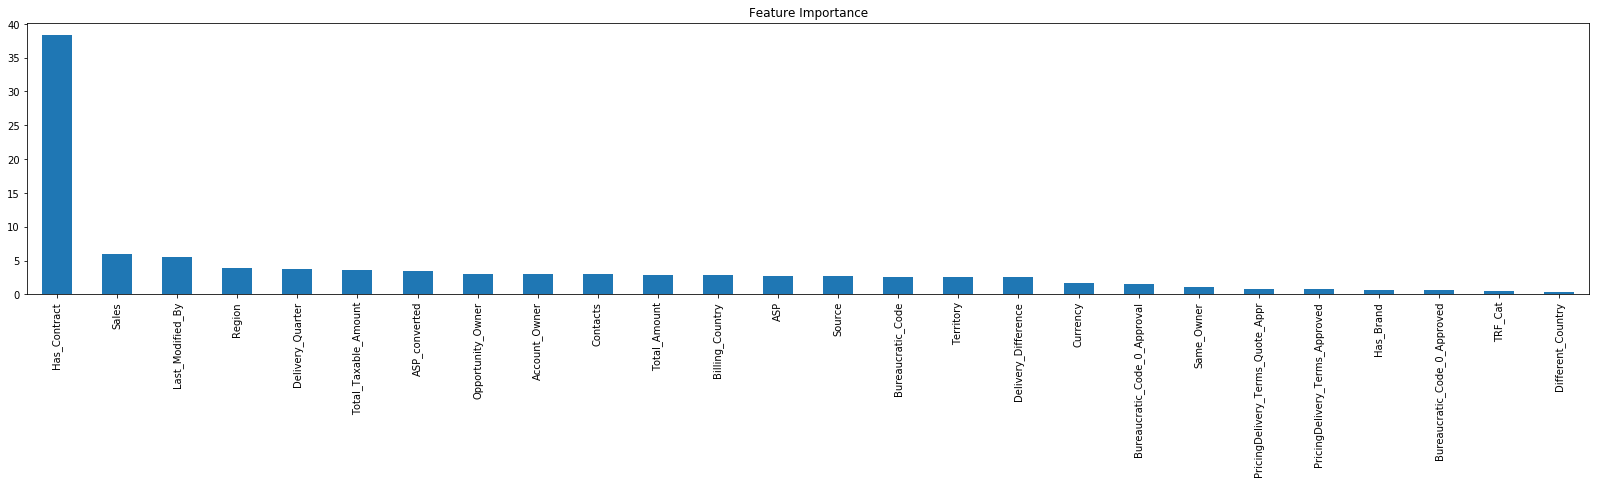

In [112]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')